In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

artificialNoAnomaly    README.md       realAWSCloudwatch  realTraffic
artificialWithAnomaly  realAdExchange  realKnownCause	  realTweets


In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, you need to use the persistence path as the following:
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 8.3MB/s eta 0:00:01


In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可:
# Also add the following code, so that every time the environment (kernel) starts, just run the following code:
import sys
sys.path.append('/home/aistudio/external-libraries')

# 题目 通过AutoEncoder实现时序数据异常检测

作者信息：[https://github.com/liu824](http://)\
创建时间：2020年10月10日10:25:53

### 介绍
#### 该脚本演示了如何使用重建卷积自动编码器模型来检测时间序列数据中的异常。
#### 数据来源于Numenta Anomaly Benchmark(NAB)数据集：[https://www.kaggle.com/boltzmannbrain/nab](http://)
#### 项目已经提供已经下载好的数据集

In [ ]:
# !unzip data/data55290/archive.zip -d work/

### 导入必要的包

In [2]:
import numpy as np
import pandas as pd
import paddle.fluid as fluid
import paddle.fluid.layers as layers
from matplotlib import pyplot as plt
from paddle.fluid.dygraph import Conv2D
from paddle.fluid.dygraph.nn import Conv2DTranspose

### 加载数据 我们将使用Numenta Anomaly Benchmark(NAB)数据集。它提供了包含标记的异常行为周期的人为时间序列数据。数据是有序的，带有时间戳的单值指标。

### 我们将使用该art_daily_small_noise.csv文件进行训练，并使用该 art_daily_jumpsup.csv文件进行测试。该数据集的简单性使我们能够有效地演示异常检测。

In [3]:
master_url_root = "E:/Mycode/data/archive/"

df_small_noise_url_suffix = "artificialNoAnomaly/artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

### 快速查看数据

In [4]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


### 可视化数据 时间序列数据无异常 我们将使用以下数据进行训练

2020-10-11 22:04:46,883-INFO: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


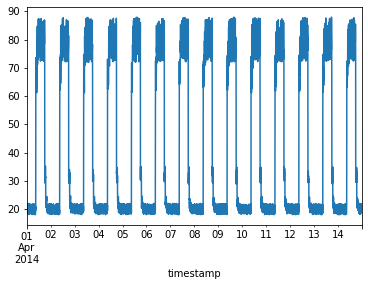

In [5]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

### 时间序列数据异常 我们将使用以下数据进行测试，并查看数据中突然跳升是否被检测为异常

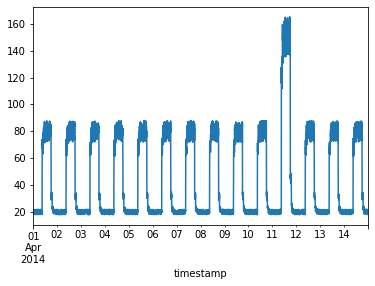

In [6]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

### 准备训练数据
### 从training timeseries数据文件中获取数据值，并对值数据进行规范化。我们有一个14天内每天5分钟的值。
 24 * 60 / 5 = 288 timesteps per day\
 288 * 14 = 4032 data points in total

In [7]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


### 创建序列 创建结合TIME_STEPS训练数据中的连续数据值的序列。时间滑窗

In [8]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


### 创建data_generete()

In [9]:
import paddle.fluid as fluid

def data_generete():
    for i in x_train:
        yield i

batch_reader = fluid.io.batch(data_generete, batch_size=128)

for id,data in enumerate(batch_reader()):
    print(id,len(data),data[0].shape)


0 128 (288, 1)
1 128 (288, 1)
2 128 (288, 1)
3 128 (288, 1)
4 128 (288, 1)
5 128 (288, 1)
6 128 (288, 1)
7 128 (288, 1)
8 128 (288, 1)
9 128 (288, 1)
10 128 (288, 1)
11 128 (288, 1)
12 128 (288, 1)
13 128 (288, 1)
14 128 (288, 1)
15 128 (288, 1)
16 128 (288, 1)
17 128 (288, 1)
18 128 (288, 1)
19 128 (288, 1)
20 128 (288, 1)
21 128 (288, 1)
22 128 (288, 1)
23 128 (288, 1)
24 128 (288, 1)
25 128 (288, 1)
26 128 (288, 1)
27 128 (288, 1)
28 128 (288, 1)
29 32 (288, 1)


### 建立模型 我们将建立卷积重建自动编码器模型。该模型将接受形状的输入，(batch_size, sequence_length, num_features)并返回相同形状的输出。在这种情况下，sequence_length288 num_features为1。

In [10]:
#飞桨中并没有1x1的卷积，下面是1x1卷积的实现方法，按照原代码每次squeeze之后会接unsqueeze,
#其实每次输入并不需要进行这么多多余的操作，因此在网络中并没有使用Conv1D，Conv1DTranspose,在此附上仅供参考
def Conv1D(input,num_filters,filter_size,stride,padding):
    y=layers.unsqueeze(input,axes=[0])
    y=layers.conv2d(y, num_filters, filter_size, stride, padding)
    y=layers.squeeze(y,axes=[0,3])
    return y
def Conv1DTranspose(input,num_filters,filter_size,stride,padding):
    y=layers.unsqueeze(input,axes=[0])
    y=layers.conv2d(y, num_filters, filter_size, stride, padding)
    y=layers.squeeze(y,axes=[0,3])
    return y

class MyModel(fluid.dygraph.Layer):
    def __init__(self):
        super(MyModel,self).__init__()
        self.conv1=Conv2D(num_channels=1,num_filters=32,filter_size=(7,1),stride=(2,1),padding=(3,0),act='relu')
        self.conv2=Conv2D(num_channels=32,num_filters=16,filter_size=(7,1),stride=(2,1),padding=(3,0),act='relu')
        self.conv2dtranspose1=Conv2DTranspose(num_channels=16,num_filters=16,filter_size=(6,1),stride=(2,1),padding=(2,0),act='relu')#paddle中没有padding='same'，为了输出对齐我对filter_size和padding进行了调整
        self.conv2dtranspose2=Conv2DTranspose(num_channels=16,num_filters=32,filter_size=(6,1),stride=(2,1),padding=(2,0),act='relu')#paddle中没有padding='same'，为了输出对齐我对filter_size和padding进行了调整
        self.conv2dtranspose3=Conv2DTranspose(num_channels=32,num_filters=1,filter_size=(7,1),stride=(1,1),padding=(3,0))
    def forward(self,input):
        y=layers.unsqueeze(input,axes=[1])
        y=self.conv1(y)
        y=layers.dropout(y, dropout_prob=0.2)
        y=self.conv2(y)
        y=self.conv2dtranspose1(y)
        y=layers.dropout(y, dropout_prob=0.2)
        y=self.conv2dtranspose2(y)
        y=self.conv2dtranspose3(y)
        y=layers.squeeze(input=y,axes=[1])
        return y


### 定义绘图函数

In [11]:
Batch=0
Batchs=[]
all_train_loss=[]
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()

### 模型训练

epoch:0,batch_id:29,train_loss:[0.12090594]
epoch:1,batch_id:29,train_loss:[0.05665541]
epoch:2,batch_id:29,train_loss:[0.04587549]
epoch:3,batch_id:29,train_loss:[0.03503494]
epoch:4,batch_id:29,train_loss:[0.0334719]
epoch:5,batch_id:29,train_loss:[0.03172474]
epoch:6,batch_id:29,train_loss:[0.0283282]
epoch:7,batch_id:29,train_loss:[0.0244086]
epoch:8,batch_id:29,train_loss:[0.0246064]
epoch:9,batch_id:29,train_loss:[0.02337067]
epoch:10,batch_id:29,train_loss:[0.02177452]
epoch:11,batch_id:29,train_loss:[0.02010795]
epoch:12,batch_id:29,train_loss:[0.01960745]
epoch:13,batch_id:29,train_loss:[0.01774275]
epoch:14,batch_id:29,train_loss:[0.01685415]
epoch:15,batch_id:29,train_loss:[0.0161995]
epoch:16,batch_id:29,train_loss:[0.01633835]
epoch:17,batch_id:29,train_loss:[0.01490983]
epoch:18,batch_id:29,train_loss:[0.01431551]
epoch:19,batch_id:29,train_loss:[0.01331822]
epoch:20,batch_id:29,train_loss:[0.01357787]
epoch:21,batch_id:29,train_loss:[0.01308259]
epoch:22,batch_id:29,trai

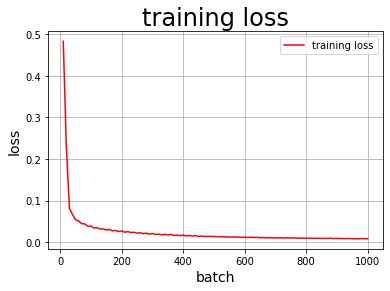

In [12]:
place = fluid.CUDAPlace(0) 
with fluid.dygraph.guard(place):
    model=MyModel() #模型实例化
    model.train() #训练模式
    # opt=fluid.optimizer.SGDOptimizer(learning_rate=train_parameters['learning_strategy']['lr'], parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.001, parameter_list=model.parameters()) 
    epochs_num=50#迭代次数
    batch_reader = fluid.io.batch(data_generete, batch_size=128)
    for pass_num in range(epochs_num):
        for batch_id, data in enumerate(batch_reader()): 
            x_data = np.array(data).astype('float32')
            y_data = np.array(data).astype('float32')
            
            x_data = fluid.dygraph.to_variable(x_data)
            y_data = fluid.dygraph.to_variable(y_data)
      
            # print(x_data.shape, y_data.shape)

            predict=model(x_data)
            # print(predict.shape)
            loss=fluid.layers.mse_loss(predict,y_data)
            avg_loss=fluid.layers.mean(loss)#获取loss值
            avg_loss.backward()       
            opt.minimize(avg_loss)    #优化器对象的minimize方法对参数进行更新 
            model.clear_gradients()   #model.clear_gradients()来重置梯度
            if batch_id!=0 and batch_id%10==0:
                Batch = Batch+10 
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
        print("epoch:{},batch_id:{},train_loss:{}".format(pass_num,batch_id,avg_loss.numpy()))     

    fluid.save_dygraph(model.state_dict(),'MyModel')#保存模型
    fluid.save_dygraph(opt.state_dict(),'MyModel')#保存模型
    print("Final loss: {}".format(avg_loss.numpy()))    
#让我们绘制训练图和验证损失图，以了解训练的进行情况。     
draw_train_loss(Batchs,all_train_loss)

### 让我们绘制训练图和验证损失图，以了解训练的进行情况。

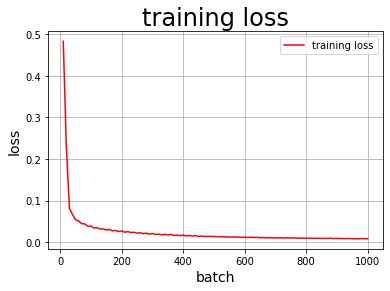

In [13]:
draw_train_loss(Batchs,all_train_loss)

### 检测异常
我们将通过确定模型重构输入数据的程度来检测异常。

在训练样本上找到MAE损失。
查找最大MAE损失值。这是我们的模型在尝试重建样本时执行的最糟糕的情况。我们将其threshold用于异常检测。
如果样本的重建损失大于该threshold 值，那么我们可以推断出该模型正在看到它不熟悉的模式。我们将此样品标记为anomaly。

batch:0 is ok
batch:10 is ok
batch:20 is ok
batch:30 is ok
batch:40 is ok
batch:50 is ok
batch:60 is ok
batch:70 is ok
batch:80 is ok
batch:90 is ok
batch:100 is ok
batch:110 is ok
batch:120 is ok
batch:130 is ok
batch:140 is ok
batch:150 is ok
batch:160 is ok
batch:170 is ok
batch:180 is ok
batch:190 is ok
batch:200 is ok
batch:210 is ok
batch:220 is ok
batch:230 is ok
batch:240 is ok
batch:250 is ok
batch:260 is ok
batch:270 is ok
batch:280 is ok
batch:290 is ok
batch:300 is ok
batch:310 is ok
batch:320 is ok
batch:330 is ok
batch:340 is ok
batch:350 is ok
batch:360 is ok
batch:370 is ok
batch:380 is ok
batch:390 is ok
batch:400 is ok
batch:410 is ok
batch:420 is ok
batch:430 is ok
batch:440 is ok
batch:450 is ok
batch:460 is ok
batch:470 is ok
batch:480 is ok
batch:490 is ok
batch:500 is ok
batch:510 is ok
batch:520 is ok
batch:530 is ok
batch:540 is ok
batch:550 is ok
batch:560 is ok
batch:570 is ok
batch:580 is ok
batch:590 is ok
batch:600 is ok
batch:610 is ok
batch:620 is ok
bat

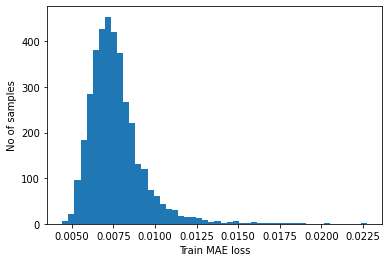

Reconstruction error threshold:  0.022722887


In [14]:
#模型评估
with fluid.dygraph.guard():
    accs = []
    model_dict, _ = fluid.load_dygraph('MyModel')
    # model = MyDNN()
    model=MyModel()
    model.load_dict(model_dict) #加载模型参数
    train_mae_loss=[]
    batch_reader = fluid.io.batch(data_generete, batch_size=1)
    for batch_id, data in enumerate(batch_reader()):
        x_data = np.array(data).astype('float32')
        x_data = fluid.dygraph.to_variable(x_data)
        x_train_pred=model(x_data)
        loss=fluid.layers.mse_loss(x_train_pred,x_data)
        mae_loss=fluid.layers.mean(loss)#获取loss值
        # train_mae_loss = np.mean(np.abs(x_train_pred - x_data), axis=1)
        train_mae_loss.append(mae_loss.numpy()[0])
        # print(train_mae_loss.numpy()[0])
        if batch_id%10==0:
            print("batch:{} is ok".format(batch_id))
    train_mae_loss=np.reshape(np.array(train_mae_loss),(np.array(train_mae_loss).shape[0],1))
    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)
    print("Reconstruction error threshold: ", threshold)   




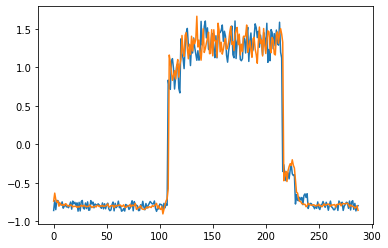

In [15]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred.numpy()[0])
plt.show()

### 准备测试数据

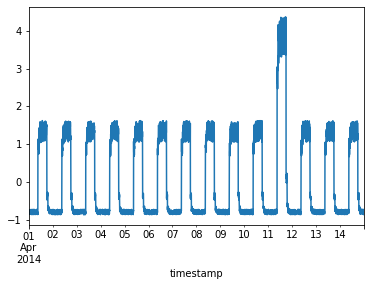

Test input shape:  (3744, 288, 1)


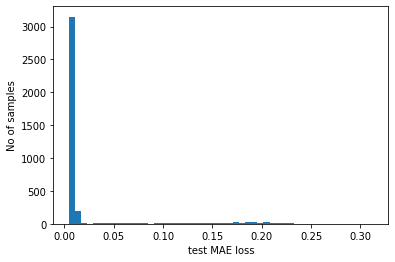

Number of anomaly samples:  389
Indices of anomaly samples:  (array([2701, 2702, 2703, 2705, 2707, 2710, 2711, 2712, 2713, 2714, 2715,
       2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726,
       2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737,
       2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748,
       2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770,
       2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781,
       2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792,
       2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825,
       2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836,
       2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2

In [16]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)
def testdata_generete():
    for i in x_test:
        yield i


#Get test MAE loss
with fluid.dygraph.guard():
    accs = []
    model_dict, _ = fluid.load_dygraph('MyModel')
    # model = MyDNN()
    model=MyModel()
    model.load_dict(model_dict) #加载模型参数
    test_mae_loss=[]
    testbatch_reader = fluid.io.batch(testdata_generete, batch_size=1)
    for batch_id, data in enumerate(testbatch_reader()):
        x_data = np.array(data).astype('float32')
        x_data = fluid.dygraph.to_variable(x_data)
        x_train_pred=model(x_data)
        loss=fluid.layers.mse_loss(x_train_pred,x_data)
        mae_loss=fluid.layers.mean(loss)#获取loss值
        # train_mae_loss = np.mean(np.abs(x_train_pred - x_data), axis=1)
        test_mae_loss.append(mae_loss.numpy()[0])
        # print(train_mae_loss.numpy()[0])
        # if batch_id%10==0:
        #     print("batch:{} is ok".format(batch_id))
    test_mae_loss=np.array(test_mae_loss)
# # Get test MAE loss.
# x_test_pred = model.predict(x_test)
# test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
# test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

### 绘制异常值图
现在我们知道异常的数据样本。这样，我们将从timestamps原始测试数据中找到相应的内容。我们将使用以下方法来做到这一点：

假设time_steps = 3，我们有10个训练值。我们x_train将如下所示：

0 1 2\
1 2 3\
2 3 4\
3 4 5\
4 5 6\
5 6 7\
6 7 8\
7 8 9\
除初始和最终time_steps-1数据值外，所有其他值都将以time_steps样本数显示 。因此，如果我们知道样本[（3，4，5），（4，5，6），（5，6，7）]是异常，则可以说数据点5是异常。

In [17]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

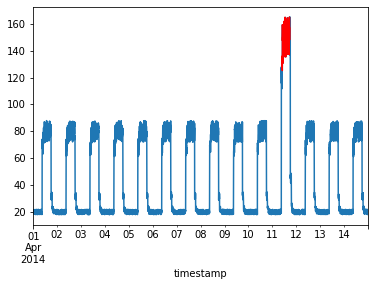

In [18]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 